In [2]:
import os 

import numpy as np
import nibabel as nb
import matplotlib.pyplot as plt

import skimage
import nilearn as nl

%matplotlib inline

In [2]:
nr_edge_voxels = 50

In [6]:
PLACE = "win"

if PLACE == "win":
    base_dir = 'D:/FSL/'
elif PLACE == "lin":
    base_dir = '/mnt/hgfs/'
        
data_dir = os.path.join(base_dir, 'shared/spinoza/data/2020_03_06/nifti')

In [ ]:
tissue_data = np.squeeze(np.array([nb.load(os.path.join(data_dir, f'anat_{tt}2line.nii.gz')).get_fdata() for tt in ['gm', 'wm', 'csf']]))

brain_mask = np.squeeze(nb.load(os.path.join(data_dir, 'bet_ss_mask.nii.gz')).get_fdata().astype(bool))

ls = np.squeeze(nb.load(os.path.join(data_dir, 'ls.nii.gz')).get_fdata())
ss = np.squeeze(nb.load(os.path.join(data_dir, 'ss.nii.gz')).get_fdata())

In [4]:
def crop(img, crop_pixels):
    return img[crop_pixels:-crop_pixels,crop_pixels:-crop_pixels]

def mask(img, mask):
    out_img = np.copy(img)
    out_img[~mask] = 0
    return out_img

cr_ls, cr_ss, cr_bm, cr_gm, cr_wm, cr_csf = (crop(img, crop_pixels=nr_edge_voxels) for img in (ls, ss, brain_mask, tissue_data[0], tissue_data[1], tissue_data[2]))
cr_m_ls, cr_m_ss, cr_m_gm, cr_m_wm, cr_m_csf = (mask(img, mask=cr_bm) for img in (cr_ls, cr_ss, cr_gm, cr_wm, cr_csf))


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


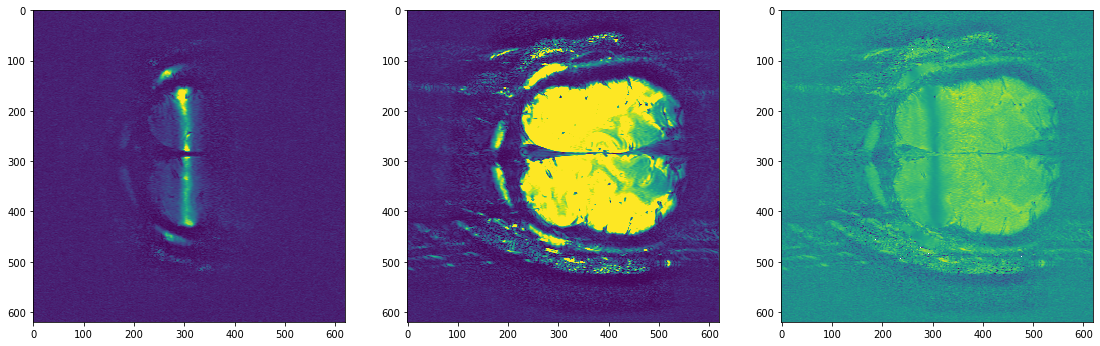

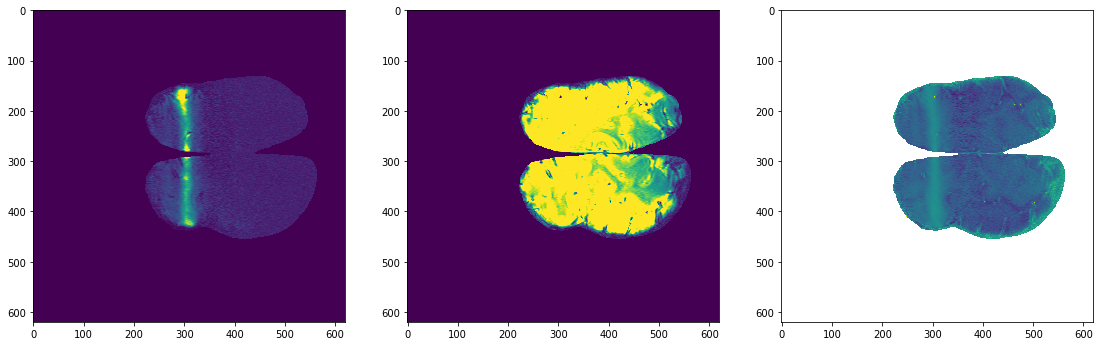

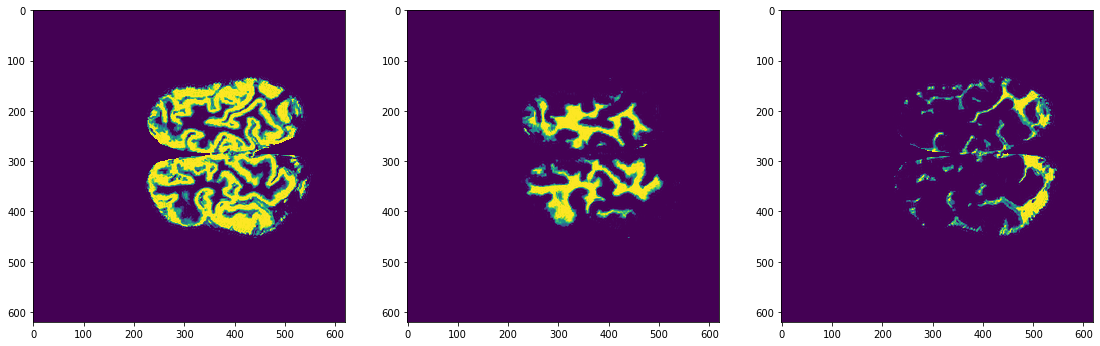

In [5]:
f, sps = plt.subplots(1, 3, figsize=(19,6))
sps[0].imshow(cr_ls, vmin=0.0, vmax=8000.0)
sps[1].imshow(cr_ss, vmin=0.0, vmax=8000.0)
sps[2].imshow(np.log(cr_ss/cr_ls))

f, sps = plt.subplots(1, 3, figsize=(19,6))
sps[0].imshow(cr_m_ls, vmin=0.0, vmax=8000.0)
sps[1].imshow(cr_m_ss, vmin=0.0, vmax=8000.0)
sps[2].imshow(np.log(cr_m_ls/cr_m_ss))

f, sps = plt.subplots(1, 3, figsize=(19,6))
sps[0].imshow(cr_m_gm, vmin=0.0, vmax=1.0)
sps[1].imshow(cr_m_wm, vmin=0.0, vmax=1.0)
sps[2].imshow(cr_m_csf, vmin=0.0, vmax=1.0)

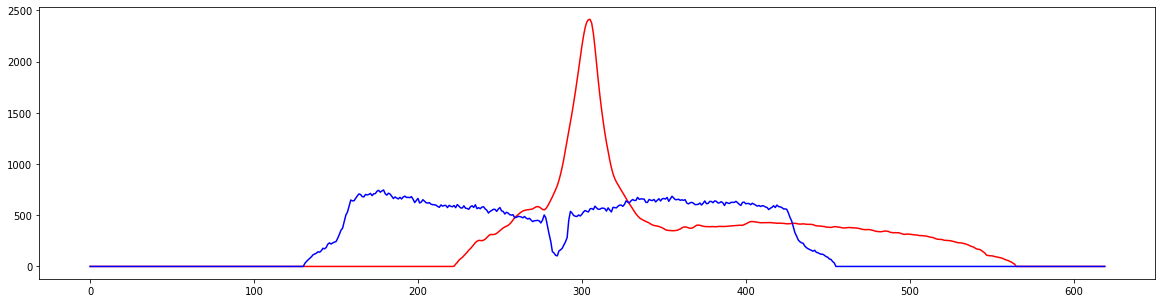

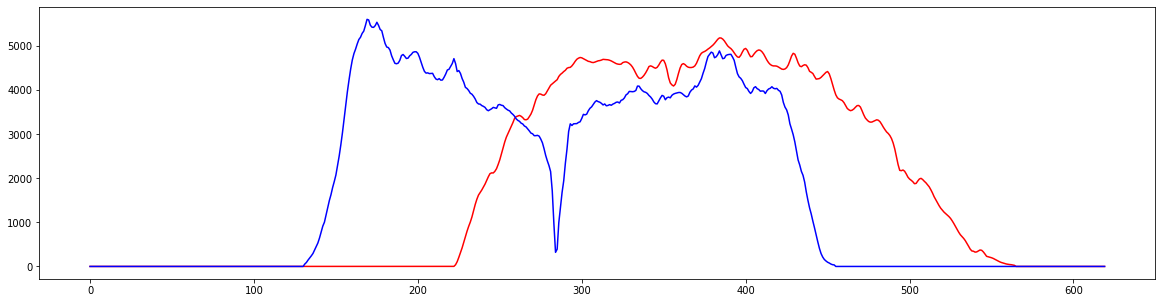

In [6]:
plt.figure(figsize=(20,5))
plt.plot(cr_m_ls.mean(0), 'r')
# plt.figure(figsize=(20,5))
plt.plot(cr_m_ls.mean(1), 'b')

plt.figure(figsize=(20,5))
plt.plot(cr_m_ss.mean(0), 'r')
# plt.figure(figsize=(20,5))
plt.plot(cr_m_ss.mean(1), 'b')

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


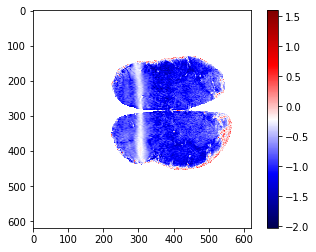

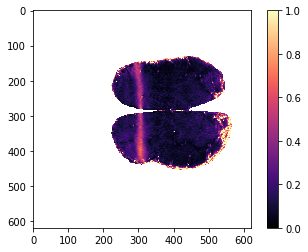

In [7]:
total = cr_m_ss+cr_m_ls
norm_ratio = cr_m_ls/cr_m_ss
plt.figure()
plt.imshow(np.log10(norm_ratio), cmap='seismic')
plt.colorbar()

plt.figure()
plt.imshow(norm_ratio, cmap='magma', vmin=0, vmax=1)
plt.colorbar()

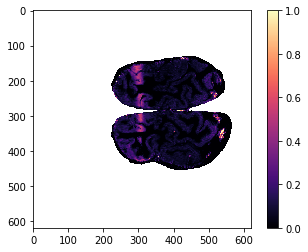

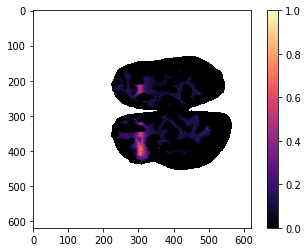

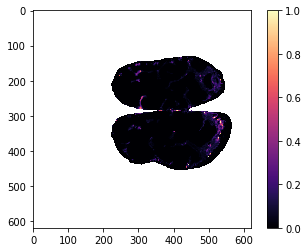

In [8]:
plt.figure()
plt.imshow(norm_ratio*cr_m_gm, cmap='magma', vmin=0, vmax=1)
plt.colorbar()
plt.figure()
plt.imshow(norm_ratio*cr_m_wm, cmap='magma', vmin=0, vmax=1)
plt.colorbar()
plt.figure()
plt.imshow(norm_ratio*cr_m_csf, cmap='magma', vmin=0, vmax=1)
plt.colorbar()

In [9]:
total_nn = np.nan_to_num(total)
norm_ratio_nn = np.nan_to_num(cr_m_ls/total_nn)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


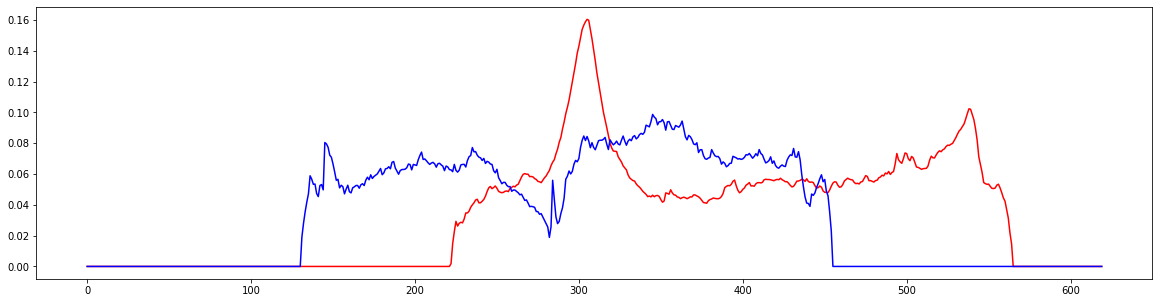

In [10]:
plt.figure(figsize=(20,5))
plt.plot(norm_ratio_nn.mean(0), 'r')
# plt.figure(figsize=(20,5))
plt.plot(norm_ratio_nn.mean(1), 'b')

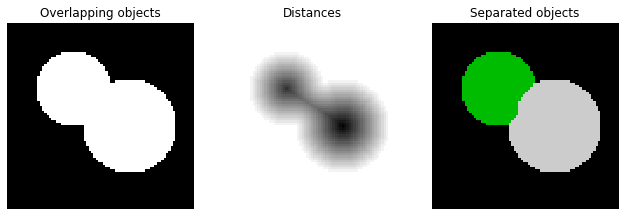

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage.feature import peak_local_max


# Generate an initial image with two overlapping circles
x, y = np.indices((80, 80))
x1, y1, x2, y2 = 28, 28, 44, 52
r1, r2 = 16, 20
mask_circle1 = (x - x1)**2 + (y - y1)**2 < r1**2
mask_circle2 = (x - x2)**2 + (y - y2)**2 < r2**2
image = np.logical_or(mask_circle1, mask_circle2)

# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(image)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)),
                            labels=image)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=image)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

In [7]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

ModuleNotFoundError: No module named 'cv2'

In [ ]:
ls = np.squeeze(nb.load(os.path.join(data_dir, 'ls.nii.gz')).get_fdata())
ss = np.squeeze(nb.load(os.path.join(data_dir, 'ss.nii.gz')).get_fdata())